# Embedded ML - Lab 2.3: TensorFlow Lite Micro


**Author:** Cristian David Araujo A. & Julian Sanchez

**Date:** 05/06/2025

Tensor Flow Lite Micro (TFLM) is a library that aims to run ML models efficiently on embedded systems. It's a C++ library that provides a version of the TensorFlow Lite interpreter that supports less types of operations and uses less memory. The library also provides helper functions for data pre- and post-processing.

In [2]:
# To run this notebook, locally as a jupyter notebook, you need to install thhe proper packages.
# follow the instructions below to set up your environment.


# 1. Crea un entorno virtual usando conda o venv
#    Por ejemplo, usando conda:
#        conda create -n [myenv] python=3.8
#        conda activate [myenv]
#    O usando venv:
#        python3 -m venv [myenv]
#        source [myenv]/bin/activate
#
# 2. Activa el entorno virtual
# 3. Instala los paquetes requeridos usando pip
# 4. Ejecuta el notebook


# Instala los paquetes requeridos:
%pip install numpy -q
%pip install pandas -q
%pip install matplotlib -q
%pip install tensorflow -q
%pip install scikit-learn -q
%pip install tensorflow-hub -q
%pip install tensorflow-datasets -q
%pip install tensorflow-estimator -q
%pip install roboflow -q
%pip install tabulate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.1 MB/s eta 0:00:00


### Learning outcomes


* Explain the basic concepts associated with TFLM
* Use the API to implement the TFLM workflow for an embedded application
* Execute TFLM code on a microcontroller-based embedded system

### TensorFlow Lite Micro workflow

TFLM's high-level workflow is rather simple:
* Generate a small TensorFlow model that can fit your target device and contains supported operations.
* Convert to a TensorFlow Lite model using the TensorFlow Lite converter, applying quantization if required.
* Convert to a C byte array using standard tools and stored it in the read-only program memory on device.
* Run inference on device using the TFLM C++ library and process the results.

### Hello World and Hello Human

After installing the Arduino IDE and the board files, you should install the Harvard_TinyMLx library that contains the TensorFlow Lite Micro and other resources and examples to build ML apps with Arduino and TFLM. Later on, depending on the application you want to build and the specific hardware to be used, you should install the propper peripheral drivers for communication, sensing and actuating.



*   Install Arduino IDE 2 from: https://downloads.arduino.cc/arduino-ide/arduino-ide_2.3.2_Linux_64bit.AppImage
*   From the boards manager install: Arduino Mbed OS Nano boards
*   Allow the linux user to access serial port: `sudo usermod -a -G dialout \<username\>` (reboot afterwards)
*   From the library manager install: Harvard_TinyMLx




Now open the **Hello World** example from the Harvard_TinyMLx library File->Examples->Harvard_TinyMLx in Arduino IDE (also available in [this repo](https://github.com/tinyMLx/arduino-library/tree/main/examples/hello_world)), compile it and run it on the microcontroller board. It is an ML model to predict a sine wave that is used to dim on and off an LED. The Arduino IDE serial monitor should also show interger numbers up and down trying to model a sine wave. This is a test app to make sure that the basic HW and SW elements, including TFLM, are working.

Inspect the code to make sure you identify and understand the main parts of the workflow.

Running on-device inference using the TFLM C++ library usually involves:

* Include the library headers
* Include the model header
* Load a model
* Instantiate operations resolver
* Allocate memory
* Instantiate interpreter
* Read and pre-process input data
* Provide inputs to the allocated tensors
* Run inference
* Get results from the output tensors
* Take action based on outputs

After you have succesfully run the Hello World example, move on to running the **Person Detection** example from the same library. Explore the code in detail to understand how to handle the **camera**.

### TinyML application development

ML applications that run on embeded systems with very limited resources are often called TinyML. In this lab the goal is to develop a simple TinyML application that uses computer vision up to its deployment on the target embedded device: **Arduino Nano 33 BLE.**

Follow these steps in order to develop your TinyML application:

1. Select two visual objects that are radically different and  assemble a dataset that contains at least hundreds or thousands of examples. You can create the images yourslef or extract them from a public database and apply data augmentation.

2. Design and train a model to classify between the two chosen objects. You can build a dense or CNN model from scratch, or use transfer learning, but you should always keep in mind the very limited memory resources of the target device as well as the image properties of the embedded camera.

3.   Export the trained model to a file and convert it to a C header by running the following linux command: `xxd -i converted_model.tflite > converted_model_data.h`

4.   Develop an Arduino code based on the Hello World and Person Detection examples, to detect whether any of the two objects are present on the camera view. Indicate the result through the RGB LED.

Include in your notebook submission both the code you developed to build the model as well as the C++ codes for the MCU.

In [2]:
# Step 1: Download the dataset from Roboflow
from roboflow import Roboflow

rf = Roboflow(api_key="w5hJLcBvvd3Y3rBjxkkU")
project = rf.workspace("eml-pb5ag").project("rock-paper-scissors-vwkqp")
version = project.version(6)
dataset = version.download("folder")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Rock-Paper-Scissors-6 in folder:: 100%|██████████| 7979/7979 [00:01<00:00, 7457.61it/s]


In [23]:
!rm -r Rock-Paper-Scissors-6

In [3]:
import os
import shutil
import random
from pathlib import Path

# Ruta base del dataset descargado por Roboflow
base_path = Path("Rock-Paper-Scissors-6")  # Ajusta si la carpeta tiene otro nombre
original_splits = ["train", "valid", "test"]

# Reunir todas las imágenes y etiquetas de todas las clases
all_items = []

for split in original_splits:
    split_path = base_path / split
    for class_dir in split_path.iterdir():
        if class_dir.is_dir():
            for img_file in class_dir.glob("*.jpg"):
                label_file = img_file.with_suffix(".txt")
                all_items.append((img_file, label_file, class_dir.name))  # (imagen, etiqueta, clase)

# Mezclar aleatoriamente los datos
random.shuffle(all_items)

# Calcular la cantidad por split
total = len(all_items)
train_count = int(0.7 * total)
valid_count = int(0.2 * total)
test_count  = total - train_count - valid_count  # el resto

# Separar los ítems
train_items = all_items[:train_count]
valid_items = all_items[train_count:train_count + valid_count]
test_items  = all_items[train_count + valid_count:]

# Nueva ruta base para reorganizar
new_base = base_path.parent / "RockPaperScissors_Split"

# Borrar carpeta de salida si existe
if new_base.exists():
    shutil.rmtree(new_base)

# Función para mover archivos
def move_items(items, split_name):
    for img_file, label_file, class_name in items:
        dest_dir = new_base / split_name / class_name
        dest_dir.mkdir(parents=True, exist_ok=True)

        # Copiar imagen
        shutil.copy(img_file, dest_dir / img_file.name)

        # Copiar etiqueta si existe
        if label_file.exists():
            shutil.copy(label_file, dest_dir / label_file.name)

# Mover los archivos a las nuevas carpetas
move_items(train_items, "train")
move_items(valid_items, "valid")
move_items(test_items, "test")

print(f"Dataset reorganizado con split 70/20/10 en: {new_base}")
print(f"Total imágenes: {total} → Train: {len(train_items)}, Valid: {len(valid_items)}, Test: {len(test_items)}")


Dataset reorganizado con split 70/20/10 en: RockPaperScissors_Split
Total imágenes: 7965 → Train: 5575, Valid: 1593, Test: 797


In [4]:
from pathlib import Path

# Ruta base del dataset
base_path = Path("RockPaperScissors_Split")

# Recorre cada subcarpeta (train, valid, test) y sus clases
for split in ["train", "valid", "test"]:
    split_path = base_path / split
    print(f"\n Split: {split}")
    if not split_path.exists():
        print("   No existe esta carpeta.")
        continue
    for class_dir in split_path.iterdir():
        if class_dir.is_dir():
            image_count = len(list(class_dir.glob("*.jpg")))
            print(f"   Clase: {class_dir.name:10s} -> {image_count:4d} imágenes")



 Split: train
   Clase: scissors   -> 1864 imágenes
   Clase: rock       -> 1849 imágenes
   Clase: paper      -> 1862 imágenes

 Split: valid
   Clase: scissors   ->  513 imágenes
   Clase: rock       ->  539 imágenes
   Clase: paper      ->  541 imágenes

 Split: test
   Clase: scissors   ->  278 imágenes
   Clase: rock       ->  267 imágenes
   Clase: paper      ->  252 imágenes


In [36]:
# Step 2: Load the dataset and prepare the data generators

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 96
BATCH_SIZE = 16

# Define the directories for training, validation, and testing
train_dir = "RockPaperScissors_Split/train"
valid_dir = "RockPaperScissors_Split/valid"
test_dir  = "RockPaperScissors_Split/test"

# Create ImageDataGenerators for training, validation, and testing
train_gen = ImageDataGenerator(rescale=1./255)
valid_gen = ImageDataGenerator(rescale=1./255)
test_gen  = ImageDataGenerator(rescale=1./255)

# Create data generators
train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_data = valid_gen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE
)


Found 5575 images belonging to 3 classes.
Found 1593 images belonging to 3 classes.
Found 797 images belonging to 3 classes.


In [37]:
# Step 3: Build and compile the model


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1)),
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()


# Train the model
EPOCHS = 50
model.fit(train_data, validation_data=valid_data, epochs=EPOCHS)

# save the model
model.save("rock_paper_scissors_model.keras")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 94, 94, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 47, 47, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │       123,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,699 (487.11 KB)

 Trainable params: 124,699 (487.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


349/349 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3742 - loss: 1.0963 - val_accuracy: 0.5148 - val_loss: 0.9342
Epoch 2/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5505 - loss: 0.8851 - val_accuracy: 0.5461 - val_loss: 0.7692
Epoch 3/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6677 - loss: 0.6902 - val_accuracy: 0.7740 - val_loss: 0.5094
Epoch 4/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8367 - loss: 0.4489 - val_accuracy: 0.8362 - val_loss: 0.4241
Epoch 5/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9024 - loss: 0.3047 - val_accuracy: 0.9102 - val_loss: 0.2889
Epoch 6/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9318 - loss: 0.2258 - val_accuracy: 0.9033 - val_loss: 0.2853
Epoch 7/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9477 - loss: 0.1685 - val_accuracy: 0.9240 - val_loss: 0.2398
Epoch 8/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9588 - loss: 0.1217 - val_accuracy: 0.943

In [38]:
# Step 4: Convert the model to tflite int8 format

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]


# Set representative dataset for quantization
# Define a representative dataset generator for post-training quantization.
# This function yields batches of input data in the correct shape and type,
# allowing the TFLite converter to calibrate the quantization ranges.
def representative_dataset_gen():
    for _ in range(100):
        # Get a batch of images from the training data generator
        data, _ = next(train_data)
        # Yield a single image as a list of tensors, as required by TFLite
        yield [tf.convert_to_tensor(data[0:1], dtype=tf.float32)]


# Assign the representative dataset generator to the converter
converter.representative_dataset = representative_dataset_gen

# Convert the model to TFLite format
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.int8  # Set input type to int8
converter.inference_output_type = tf.int8  # Set output type to int8

# Convert the model to TFLite format with optimizations
tflite_model = converter.convert()

# Save the converted TFLite model to a file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

# Convert the model to C header file
!xxd -i model.tflite > model.cpp



Saved artifact at '/tmp/tmpzwzy6imd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='keras_tensor_16')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139873779382032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873400162448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139872330867984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139872330868560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139872330867600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139872330869328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139872330868752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139872330870096: TensorSpec(shape=(), dtype=tf.resource, name=None)


Statistics for quantized inputs were expected, but not specified; continuing anyway.


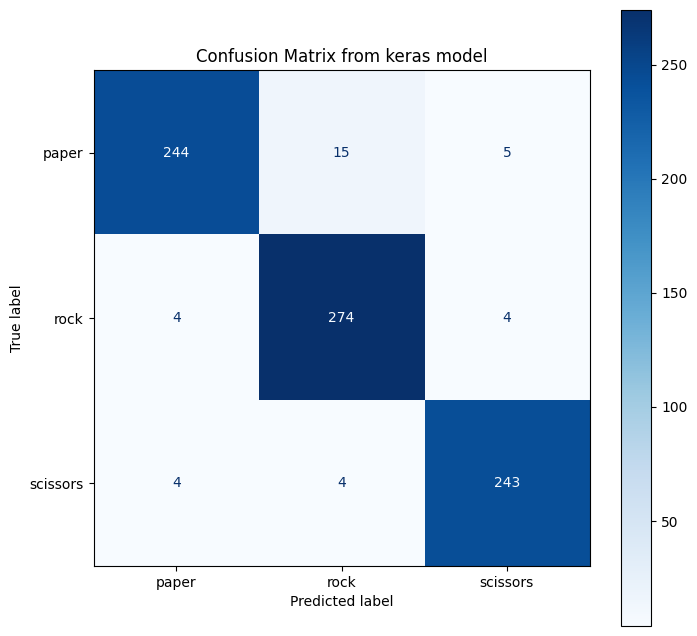

Classification Report:
[[244  15   5]
 [  4 274   4]
 [  4   4 243]]
classification_report:
              precision    recall  f1-score   support

       paper       0.97      0.92      0.95       264
        rock       0.94      0.97      0.95       282
    scissors       0.96      0.97      0.97       251

    accuracy                           0.95       797
   macro avg       0.96      0.95      0.95       797
weighted avg       0.96      0.95      0.95       797



In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Reset the test data generator to ensure it starts from the beginning
test_data.reset()

# Initialize lists to store true labels and predicted labels
y_true = []
y_pred = []

# predict on the test data
for i in range(len(test_data)):
    # Get a batch of images and labels
    x_batch, y_batch = test_data[i]
    preds = model.predict(x_batch, verbose=0)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

class_names = list(test_data.class_indices.keys())

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))


# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix from keras model')
plt.show()

# Print the confusion matrix
print("Classification Report:")
print(cm)

# Print the classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("classification_report:")
print(report)


Input scale: 0.003921568859368563 Input zero point: -128
Output scale: 0.00390625 Output zero point: -128


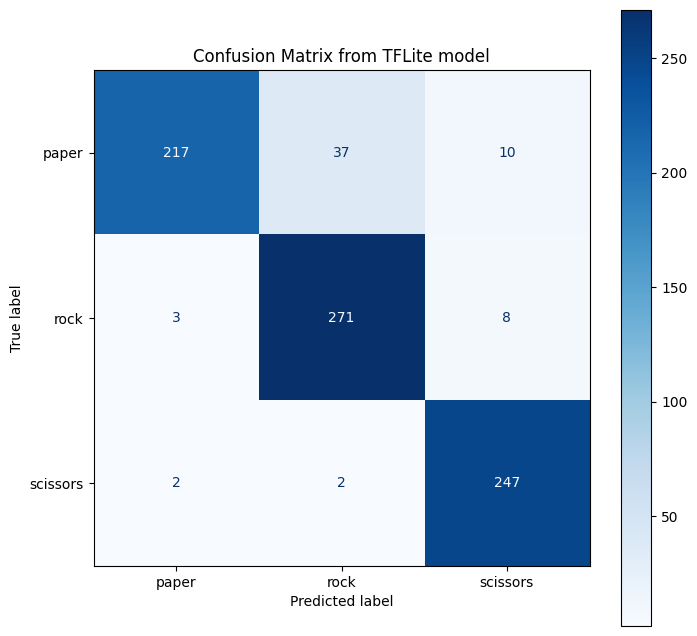

Confusion matrix:
[[217  37  10]
 [  3 271   8]
 [  2   2 247]]
classification_report:
              precision    recall  f1-score   support

       paper       0.98      0.82      0.89       264
        rock       0.87      0.96      0.92       282
    scissors       0.93      0.98      0.96       251

    accuracy                           0.92       797
   macro avg       0.93      0.92      0.92       797
weighted avg       0.93      0.92      0.92       797



In [40]:
# Evaluate the tflite model

interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_scale, input_zero_point = input_details[0]['quantization']
output_scale, output_zero_point = output_details[0]['quantization']


print("Input scale:", input_scale, "Input zero point:", input_zero_point)
print("Output scale:", output_scale, "Output zero point:", output_zero_point)


y_true = []
y_pred = []

for i in range(len(test_data)):

    x_batch, y_batch = test_data[i]

    for img, label in zip(x_batch, y_batch):
        # Step 1: Resize the image to (128, 128)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)).numpy()

        # Step 2: Ensure single channel (grayscale)
        if img.ndim == 2:
            img = np.expand_dims(img, axis=-1)

        # Step 3: Quantize the image using the scale and zero point
        img_quant = (img / input_scale) + input_zero_point
        img_quant = np.clip(img_quant, 0, 255).astype(np.int8)

        # Step 4: Add batch dimension
        input_tensor = np.expand_dims(img_quant, axis=0)

        # Step 5: Set the input tensor
        interpreter.set_tensor(input_details[0]['index'], input_tensor)

        # Step 6: Invoke the interpreter
        interpreter.invoke()

        # Step 7: Get the output tensor
        output = interpreter.get_tensor(output_details[0]['index'])

        # Step 8: Dequantize the output tensor
        output = output_scale * (output.astype(np.float32) - output_zero_point)

        # Step 9: Get the predicted class
        pred_label = np.argmax(output)
        true_label = np.argmax(label)

        y_true.append(true_label)
        y_pred.append(pred_label)


# Evaluate the tflite model
class_names = list(test_data.class_indices.keys())

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix from TFLite model')
plt.show()

# Print the confusion matrix
print("Confusion matrix:")
print(cm)

# Print the classification report
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
print("classification_report:")
print(report)

In [41]:
from tabulate import tabulate

def print_tensor_details(details, tensor_type):
    print(f"{tensor_type} Tensor Details:\n")

    # Prepare table data
    table = []
    for detail in details:
        name = detail['name']
        shape = str(detail['shape'])
        dtype = str(detail['dtype']).replace("<class 'numpy.", "").replace("'>", "")
        scale, zero_point = detail['quantization']
        table.append([name, shape, dtype, scale, zero_point])

    headers = ["Name", "Shape", "Dtype", "Scale", "Zero Point"]
    print(tabulate(table, headers=headers, tablefmt="fancy_grid"))
    print()


In [42]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("=== Model Format Details ===\n")
print_tensor_details(input_details, "Input")
print_tensor_details(output_details, "Output")
print("============================\n")

=== Model Format Details ===

Input Tensor Details:

╒═══════════════════════════════════╤═══════════════╤═════════╤════════════╤══════════════╕
│ Name                              │ Shape         │ Dtype   │      Scale │   Zero Point │
╞═══════════════════════════════════╪═══════════════╪═════════╪════════════╪══════════════╡
│ serving_default_keras_tensor_16:0 │ [ 1 96 96  1] │ int8    │ 0.00392157 │         -128 │
╘═══════════════════════════════════╧═══════════════╧═════════╧════════════╧══════════════╛

Output Tensor Details:

╒═════════════════════════════╤═════════╤═════════╤════════════╤══════════════╕
│ Name                        │ Shape   │ Dtype   │      Scale │   Zero Point │
╞═════════════════════════════╪═════════╪═════════╪════════════╪══════════════╡
│ StatefulPartitionedCall_1:0 │ [1 3]   │ int8    │ 0.00390625 │         -128 │
╘═════════════════════════════╧═════════╧═════════╧════════════╧══════════════╛




In [44]:
import os
import tensorflow as tf
from tabulate import tabulate

def sizeof_fmt(num, suffix='B'):
    # función para mostrar tamaños legibles
    for unit in ['','K','M','G','T','P','E','Z']:
        if abs(num) < 1024.0:
            return f"{num:3.2f} {unit}{suffix}"
        num /= 1024.0
    return f"{num:.2f} Y{suffix}"

# Rutas a tus modelos
model_cpp_path = "model.cpp"
model_tflite_path = "model.tflite"
model_keras_path = "rock_paper_scissors_model.keras"

# Obtener tamaños de archivos
cpp_size = os.path.getsize(model_cpp_path) if os.path.exists(model_cpp_path) else None
tflite_size = os.path.getsize(model_tflite_path) if os.path.exists(model_tflite_path) else None
keras_size = os.path.getsize(model_keras_path) if os.path.exists(model_keras_path) else None

# Obtener número de parámetros (solo para modelo Keras)
keras_params = None
if keras_size is not None:
    model = tf.keras.models.load_model(model_keras_path)
    keras_params = model.count_params()

# Obtener detalles de modelo TFLite (número de tensores)
tflite_tensors = None
if tflite_size is not None:
    interpreter = tf.lite.Interpreter(model_path=model_tflite_path)
    interpreter.allocate_tensors()
    tflite_tensors = len(interpreter.get_tensor_details())

# Preparar datos para tabla
table_data = [
    ["model.cpp", sizeof_fmt(cpp_size) if cpp_size else "No encontrado", "N/A"],
    ["model.tflite", sizeof_fmt(tflite_size) if tflite_size else "No encontrado", f"Tensores: {tflite_tensors}" if tflite_tensors else "N/A"],
    ["model.keras", sizeof_fmt(keras_size) if keras_size else "No encontrado", f"Parámetros: {keras_params}" if keras_params else "N/A"],
]

# Mostrar tabla con tabulate
print(tabulate(table_data, headers=["Modelo", "Tamaño", "Características"], tablefmt="grid"))



+--------------+-----------+--------------------+
| Modelo       | Tamaño    | Características    |
+==============+===========+====================+
| model.cpp    | 782.66 KB | N/A                |
+--------------+-----------+--------------------+
| model.tflite | 126.91 KB | Tensores: 18       |
+--------------+-----------+--------------------+
| model.keras  | 1.46 MB   | Parámetros: 124699 |
+--------------+-----------+--------------------+


# Conclusions

In this practice, it was demonstrated how to convert a model from scratch into a final, useful application using TensorFlow Lite Micro. This notebook presents the complete workflow by applying previously acquired knowledge from past practices. The selected model in this case was designed to classify hand gestures for the rock-paper-scissors game.

The creation of the model involved a simple convolutional neural network (CNN) architecture tailored for image classification using grayscale images of size (IMG_SIZE, IMG_SIZE, 1). The model consists of:

1.  An input layer that accepts 2D grayscale images.

2. Two consecutive pairs of Conv2D and MaxPooling2D layers. Each Conv2D layer applies 8 filters of size (3,3) with ReLU activation to extract spatial features such as edges or textures, while the MaxPooling2D layers reduce spatial dimensions to help minimize overfitting and computational cost.

3. A Flatten layer to convert the 2D feature maps into a 1D vector.

4. A Dense layer with 32 neurons and ReLU activation to learn complex patterns.

5. A final Dense layer with 3 output neurons and softmax activation to produce a probability distribution over the three classes (rock, paper, scissors).

Once trained, the model was converted to TensorFlow Lite and subsequently to TensorFlow Lite Micro format to run efficiently on low-resource embedded systems such as microcontrollers. This practice demonstrated the full pipeline—from designing a model from scratch to deploying it as a real-time embedded application.

A comparison between the original and converted models revealed that the TensorFlow model achieved an accuracy of 79%, with balanced precision and recall across all three classes. However, after conversion, the TensorFlow Lite model's accuracy dropped to 64%, with a significant decrease in performance when classifying the "paper" gesture.

The size of the models decreases significantly when converting from Keras (1.46 MB) to TFLite (126.91 KB), showing an effective optimization for deployment. The .cpp model (782.66 KB) is intermediate, possibly due to compiled overhead. Overall, TFLite offers the smallest and most efficient format for edge devices.

Despite this, the TFLite model maintained a high recall for "rock" and "scissors", demonstrating that even simple models can be effectively adapted to embedded environments, with acceptable trade-offs in accuracy for the benefit of lightweight deployment.